In [1]:
import numpy as np

from TraceSimulator import TraceSimulator
from trace_IO import *
from OptimumFilter import *
from OF import *
import matplotlib.pyplot as plt


In [2]:
sampling_frequency = 3906250
template_1 = np.load("./sub_ch_template.npy")
template_2 = np.load("./vac_ch45_low_eng.npy")
template_3 = np.load("./vac_ch46plus_low_eng.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")

# Initialize Optimum Filter
trigger_1 = OFtrigger(template_1, noise_psd, sampling_frequency)
trigger_2 = OFtrigger(template_2, noise_psd, sampling_frequency)
trigger_3 = OFtrigger(template_3, noise_psd, sampling_frequency)


In [3]:
loaded_traces = load_traces_from_zstd("/ceph/dwong/trigger_samplesMMC_noise_1000.zst", n_traces=1000)
loaded_traces.shape

(1000, 54, 32768)

In [4]:
n_events = loaded_traces.shape[0]
n_channels = loaded_traces.shape[1]

# Arrays to store amplitudes and chisq values for all events
all_amps = np.zeros((n_events, n_channels))
all_chisqs = np.zeros((n_events, n_channels))

# Optional: templates for plotting/debugging
templates = {
    "1": trigger_1._template,
    "2": trigger_2._template,
    "3": trigger_3._template,
}

for i in range(n_events):
    traces = loaded_traces[i]  # shape: (54, 32768)

    for ch in range(n_channels):
        if ch <= 44:
            amp, chisq = trigger_1.fit(traces[ch])
        elif ch == 45:
            amp, chisq = trigger_2.fit(traces[ch])
        else:
            amp, chisq = trigger_3.fit(traces[ch])

        all_amps[i, ch] = amp
        all_chisqs[i, ch] = chisq


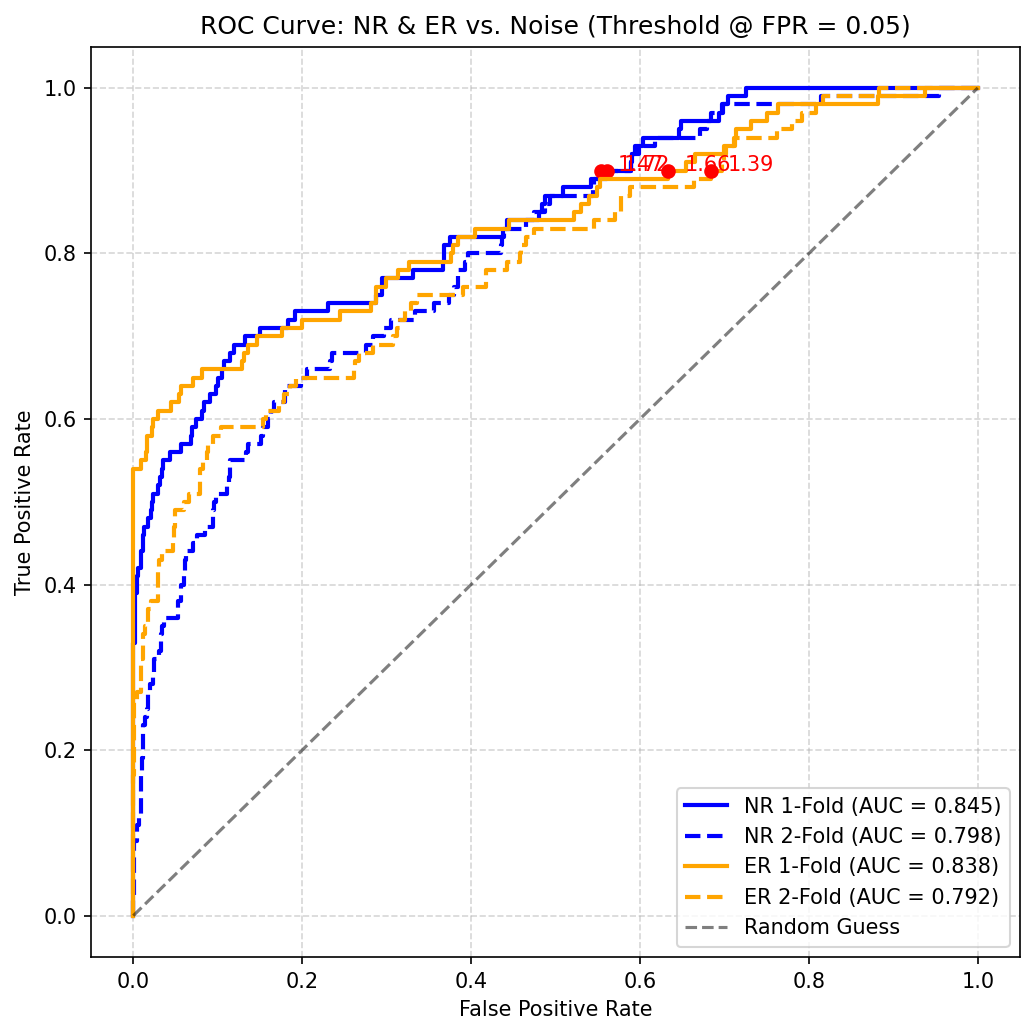

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# === Load traces ===
loaded_traces_neg = load_traces_from_zstd("/ceph/dwong/trigger_samplesMMC_noise_1000.zst", n_traces=1000)
loaded_traces_NR = load_traces_from_zstd("/ceph/dwong/trigger_samples/NR/traces_energy_30.zst", n_traces=100)
loaded_traces_ER = load_traces_from_zstd("/ceph/dwong/trigger_samples/ER/traces_energy_30.zst", n_traces=100)

def compute_amplitudes(traces):
    n_events = traces.shape[0]
    n_channels = traces.shape[1]
    all_amps = np.zeros((n_events, n_channels))
    for i in range(n_events):
        event = traces[i]
        for ch in range(n_channels):
            if ch <= 44:
                amp, _ = trigger_1.fit(event[ch])
            elif ch == 45:
                amp, _ = trigger_2.fit(event[ch])
            else:
                amp, _ = trigger_3.fit(event[ch])
            all_amps[i, ch] = amp
    return all_amps

# === Compute amplitudes ===
amps_neg = compute_amplitudes(loaded_traces_neg)
amps_NR  = compute_amplitudes(loaded_traces_NR)
amps_ER  = compute_amplitudes(loaded_traces_ER)

# === Score functions ===
def fold_scores(amps, fold_n):
    return np.partition(amps, -fold_n, axis=1)[:, -fold_n]

score_1fold_neg = np.max(amps_neg, axis=1)
score_2fold_neg = fold_scores(amps_neg, 2)

score_1fold_NR = np.max(amps_NR, axis=1)
score_2fold_NR = fold_scores(amps_NR, 2)

score_1fold_ER = np.max(amps_ER, axis=1)
score_2fold_ER = fold_scores(amps_ER, 2)

# === ROC + threshold finder ===
def compute_roc_with_threshold(scores_signal, scores_noise, target_tpr=0.9):
    y_true = np.concatenate([np.zeros_like(scores_noise), np.ones_like(scores_signal)])
    y_scores = np.concatenate([scores_noise, scores_signal])
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc_val = auc(fpr, tpr)
    idx = np.argmin(np.abs(tpr - target_tpr))
    return fpr, tpr, auc_val, thresholds[idx], fpr[idx], tpr[idx]


# === Compute all curves ===
fpr_NR_1, tpr_NR_1, auc_NR_1, th_NR_1, fx_NR_1, ty_NR_1 = compute_roc_with_threshold(score_1fold_NR, score_1fold_neg, target_tpr=0.9)
fpr_NR_2, tpr_NR_2, auc_NR_2, th_NR_2, fx_NR_2, ty_NR_2 = compute_roc_with_threshold(score_2fold_NR, score_2fold_neg, target_tpr=0.9)
fpr_ER_1, tpr_ER_1, auc_ER_1, th_ER_1, fx_ER_1, ty_ER_1 = compute_roc_with_threshold(score_1fold_ER, score_1fold_neg, target_tpr=0.9)
fpr_ER_2, tpr_ER_2, auc_ER_2, th_ER_2, fx_ER_2, ty_ER_2 = compute_roc_with_threshold(score_2fold_ER, score_2fold_neg, target_tpr=0.9)


# === Plot ===
plt.figure(figsize=(7, 7), dpi=150)

# NR
plt.plot(fpr_NR_1, tpr_NR_1, color='blue', linewidth=2, label=f"NR 1-Fold (AUC = {auc_NR_1:.3f})")
plt.plot(fpr_NR_2, tpr_NR_2, '--', color='blue', linewidth=2, label=f"NR 2-Fold (AUC = {auc_NR_2:.3f})")
plt.plot(fx_NR_1, ty_NR_1, 'ro')
plt.text(fx_NR_1 + 0.02, ty_NR_1, f'{th_NR_1:.2f}', color='red')
plt.plot(fx_NR_2, ty_NR_2, 'ro')
plt.text(fx_NR_2 + 0.02, ty_NR_2, f'{th_NR_2:.2f}', color='red')

# ER
plt.plot(fpr_ER_1, tpr_ER_1, color='orange', linewidth=2, label=f"ER 1-Fold (AUC = {auc_ER_1:.3f})")
plt.plot(fpr_ER_2, tpr_ER_2, '--', color='orange', linewidth=2, label=f"ER 2-Fold (AUC = {auc_ER_2:.3f})")
plt.plot(fx_ER_1, ty_ER_1, 'ro')
plt.text(fx_ER_1 + 0.02, ty_ER_1, f'{th_ER_1:.2f}', color='red')
plt.plot(fx_ER_2, ty_ER_2, 'ro')
plt.text(fx_ER_2 + 0.02, ty_ER_2, f'{th_ER_2:.2f}', color='red')

# Random guess
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: NR & ER vs. Noise (Threshold @ FPR = 0.05)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [6]:
from sklearn.metrics import roc_curve

# === Compute raw ROC to inspect threshold ranges ===
# NR 2-fold
y_NR = np.ones_like(score_2fold_NR)
y_neg = np.zeros_like(score_2fold_neg)
y_true_NR = np.concatenate([y_neg, y_NR])
scores_NR_2fold = np.concatenate([score_2fold_neg, score_2fold_NR])
fpr_NR2, tpr_NR2, thresholds_NR2 = roc_curve(y_true_NR, scores_NR_2fold)

print("NR 2-Fold Threshold Range:")
print(f"min = {thresholds_NR2.min():.3f}, max = {thresholds_NR2.max():.3f}")
print("Sample thresholds:", thresholds_NR2[:10])

# ER 2-fold
y_ER = np.ones_like(score_2fold_ER)
y_true_ER = np.concatenate([y_neg, y_ER])
scores_ER_2fold = np.concatenate([score_2fold_neg, score_2fold_ER])
fpr_ER2, tpr_ER2, thresholds_ER2 = roc_curve(y_true_ER, scores_ER_2fold)

print("\nER 2-Fold Threshold Range:")
print(f"min = {thresholds_ER2.min():.3f}, max = {thresholds_ER2.max():.3f}")
print("Sample thresholds:", thresholds_ER2[:10])


NR 2-Fold Threshold Range:
min = 0.755, max = inf
Sample thresholds: [       inf 2.58769707 2.57417415 2.51493759 2.33724533 2.28973018
 2.27186836 2.26238792 2.25387232 2.24900521]

ER 2-Fold Threshold Range:
min = 0.755, max = inf
Sample thresholds: [       inf 4.67339115 2.61372461 2.51493759 2.34249002 2.28973018
 2.28066198 2.24900521 2.20382961 2.17488475]


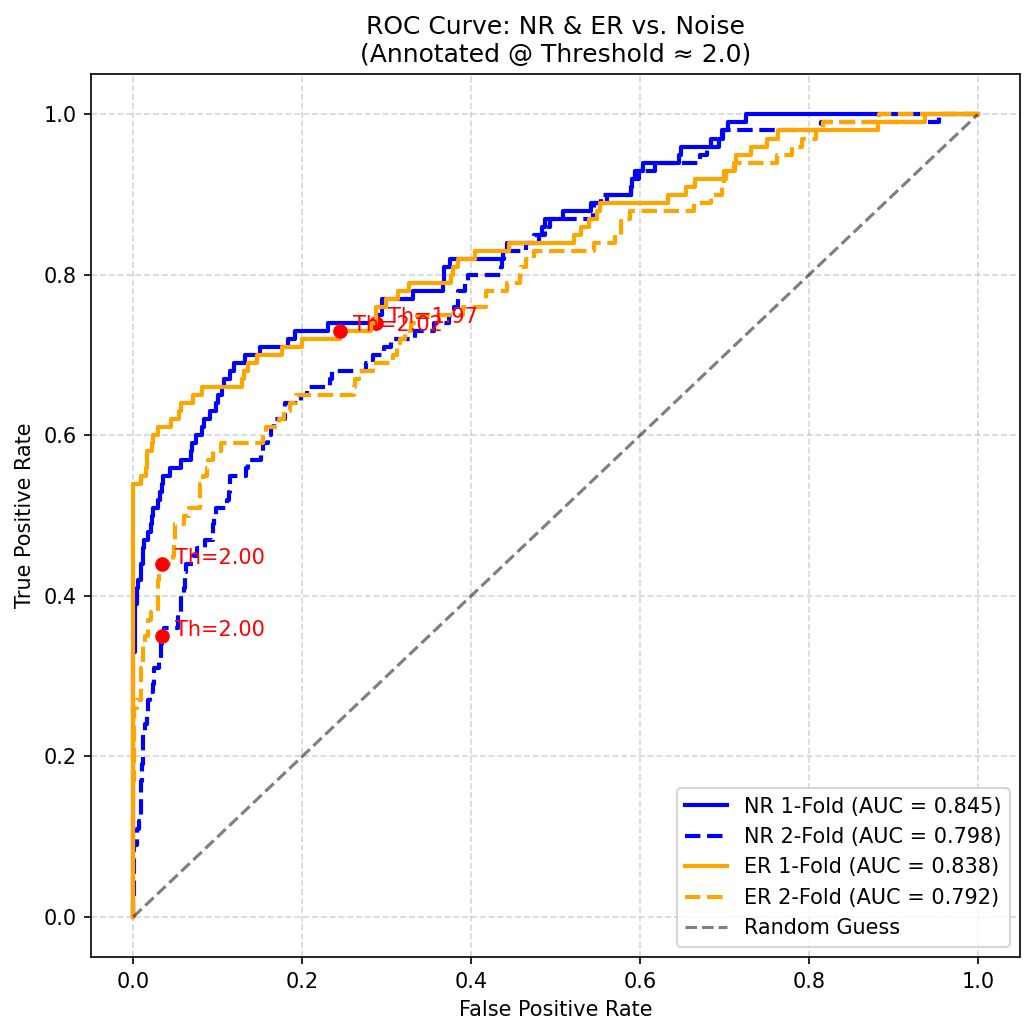

NR 1-Fold @ Th=2 → FPR=0.2870, TPR=0.7400
NR 2-Fold @ Th=2 → FPR=0.0340, TPR=0.3500
ER 1-Fold @ Th=2 → FPR=0.2450, TPR=0.7300
ER 2-Fold @ Th=2 → FPR=0.0340, TPR=0.4400


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# === Load traces ===
loaded_traces_neg = load_traces_from_zstd("/ceph/dwong/trigger_samplesMMC_noise_1000.zst", n_traces=1000)
loaded_traces_NR = load_traces_from_zstd("/ceph/dwong/trigger_samples/NR/traces_energy_30.zst", n_traces=100)
loaded_traces_ER = load_traces_from_zstd("/ceph/dwong/trigger_samples/ER/traces_energy_30.zst", n_traces=100)

def compute_amplitudes(traces):
    n_events = traces.shape[0]
    n_channels = traces.shape[1]
    all_amps = np.zeros((n_events, n_channels))
    for i in range(n_events):
        event = traces[i]
        for ch in range(n_channels):
            if ch <= 44:
                amp, _ = trigger_1.fit(event[ch])
            elif ch == 45:
                amp, _ = trigger_2.fit(event[ch])
            else:
                amp, _ = trigger_3.fit(event[ch])
            all_amps[i, ch] = amp
    return all_amps

# === Compute amplitudes ===
amps_neg = compute_amplitudes(loaded_traces_neg)
amps_NR = compute_amplitudes(loaded_traces_NR)
amps_ER = compute_amplitudes(loaded_traces_ER)

# === Score functions ===
def fold_scores(amps, fold_n):
    return np.partition(amps, -fold_n, axis=1)[:, -fold_n]

# === 1-fold and 2-fold scores ===
score_1fold_neg = np.max(amps_neg, axis=1)
score_2fold_neg = fold_scores(amps_neg, 2)

score_1fold_NR = np.max(amps_NR, axis=1)
score_2fold_NR = fold_scores(amps_NR, 2)

score_1fold_ER = np.max(amps_ER, axis=1)
score_2fold_ER = fold_scores(amps_ER, 2)

# === Labels ===
y_neg = np.zeros_like(score_1fold_neg)
y_NR = np.ones_like(score_1fold_NR)
y_ER = np.ones_like(score_1fold_ER)

# === ROC helper ===
def compute_roc(y_pos, scores_pos, scores_neg):
    y_true = np.concatenate([np.zeros_like(scores_neg), np.ones_like(y_pos)])
    y_scores = np.concatenate([scores_neg, scores_pos])
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc_val = auc(fpr, tpr)
    return fpr, tpr, thresholds, auc_val

# === Threshold annotation helper ===
def find_point_at_threshold(fpr, tpr, thresholds, target_threshold):
    idx = np.argmin(np.abs(thresholds - target_threshold))
    return thresholds[idx], fpr[idx], tpr[idx]

# === Compute ROC and annotate for NR ===
fpr_NR_1, tpr_NR_1, th_NR_1, auc_NR_1 = compute_roc(y_NR, score_1fold_NR, score_1fold_neg)
fpr_NR_2, tpr_NR_2, th_NR_2, auc_NR_2 = compute_roc(y_NR, score_2fold_NR, score_2fold_neg)
thresh_NR_1, fx_NR_1, ty_NR_1 = find_point_at_threshold(fpr_NR_1, tpr_NR_1, th_NR_1, target_threshold=2.0)
thresh_NR_2, fx_NR_2, ty_NR_2 = find_point_at_threshold(fpr_NR_2, tpr_NR_2, th_NR_2, target_threshold=2.0)

# === Compute ROC and annotate for ER ===
fpr_ER_1, tpr_ER_1, th_ER_1, auc_ER_1 = compute_roc(y_ER, score_1fold_ER, score_1fold_neg)
fpr_ER_2, tpr_ER_2, th_ER_2, auc_ER_2 = compute_roc(y_ER, score_2fold_ER, score_2fold_neg)
thresh_ER_1, fx_ER_1, ty_ER_1 = find_point_at_threshold(fpr_ER_1, tpr_ER_1, th_ER_1, target_threshold=2.0)
thresh_ER_2, fx_ER_2, ty_ER_2 = find_point_at_threshold(fpr_ER_2, tpr_ER_2, th_ER_2, target_threshold=2.0)

# === Plot ===
plt.figure(figsize=(7, 7), dpi=150)

# NR (blue)
plt.plot(fpr_NR_1, tpr_NR_1, color='blue', linewidth=2, label=f"NR 1-Fold (AUC = {auc_NR_1:.3f})")
plt.plot(fpr_NR_2, tpr_NR_2, '--', color='blue', linewidth=2, label=f"NR 2-Fold (AUC = {auc_NR_2:.3f})")
plt.plot(fx_NR_1, ty_NR_1, 'ro')
plt.text(fx_NR_1 + 0.015, ty_NR_1, f'Th={thresh_NR_1:.2f}', color='red')
plt.plot(fx_NR_2, ty_NR_2, 'ro')
plt.text(fx_NR_2 + 0.015, ty_NR_2, f'Th={thresh_NR_2:.2f}', color='red')

# ER (orange)
plt.plot(fpr_ER_1, tpr_ER_1, color='orange', linewidth=2, label=f"ER 1-Fold (AUC = {auc_ER_1:.3f})")
plt.plot(fpr_ER_2, tpr_ER_2, '--', color='orange', linewidth=2, label=f"ER 2-Fold (AUC = {auc_ER_2:.3f})")
plt.plot(fx_ER_1, ty_ER_1, 'ro')
plt.text(fx_ER_1 + 0.015, ty_ER_1, f'Th={thresh_ER_1:.2f}', color='red')
plt.plot(fx_ER_2, ty_ER_2, 'ro')
plt.text(fx_ER_2 + 0.015, ty_ER_2, f'Th={thresh_ER_2:.2f}', color='red')

# Random
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: NR & ER vs. Noise\n(Annotated @ Threshold ≈ 2.0)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# === Print threshold info ===
print(f"NR 1-Fold @ Th=2 → FPR={fx_NR_1:.4f}, TPR={ty_NR_1:.4f}")
print(f"NR 2-Fold @ Th=2 → FPR={fx_NR_2:.4f}, TPR={ty_NR_2:.4f}")
print(f"ER 1-Fold @ Th=2 → FPR={fx_ER_1:.4f}, TPR={ty_ER_1:.4f}")
print(f"ER 2-Fold @ Th=2 → FPR={fx_ER_2:.4f}, TPR={ty_ER_2:.4f}")


Processing ER energy = 5 eV
Processing ER energy = 10 eV
Processing ER energy = 15 eV
Processing ER energy = 20 eV
Processing ER energy = 25 eV
Processing ER energy = 30 eV
Processing ER energy = 35 eV
Processing ER energy = 40 eV
Processing ER energy = 45 eV
Processing ER energy = 50 eV


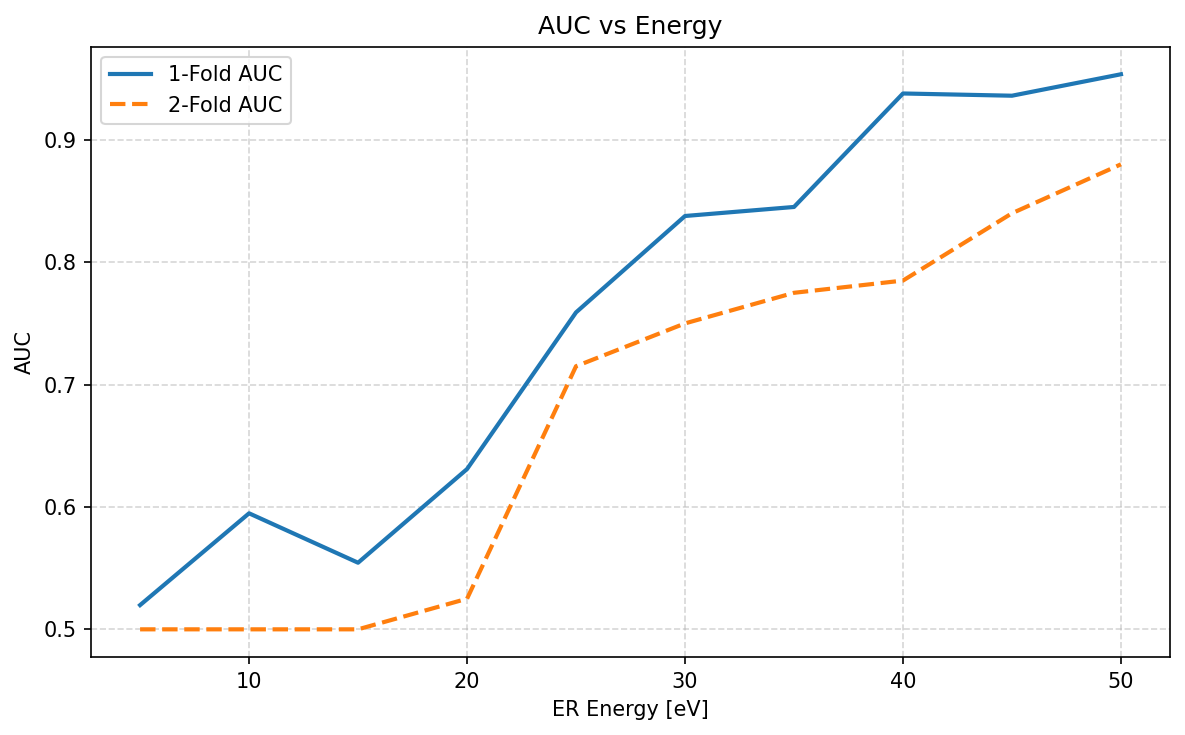

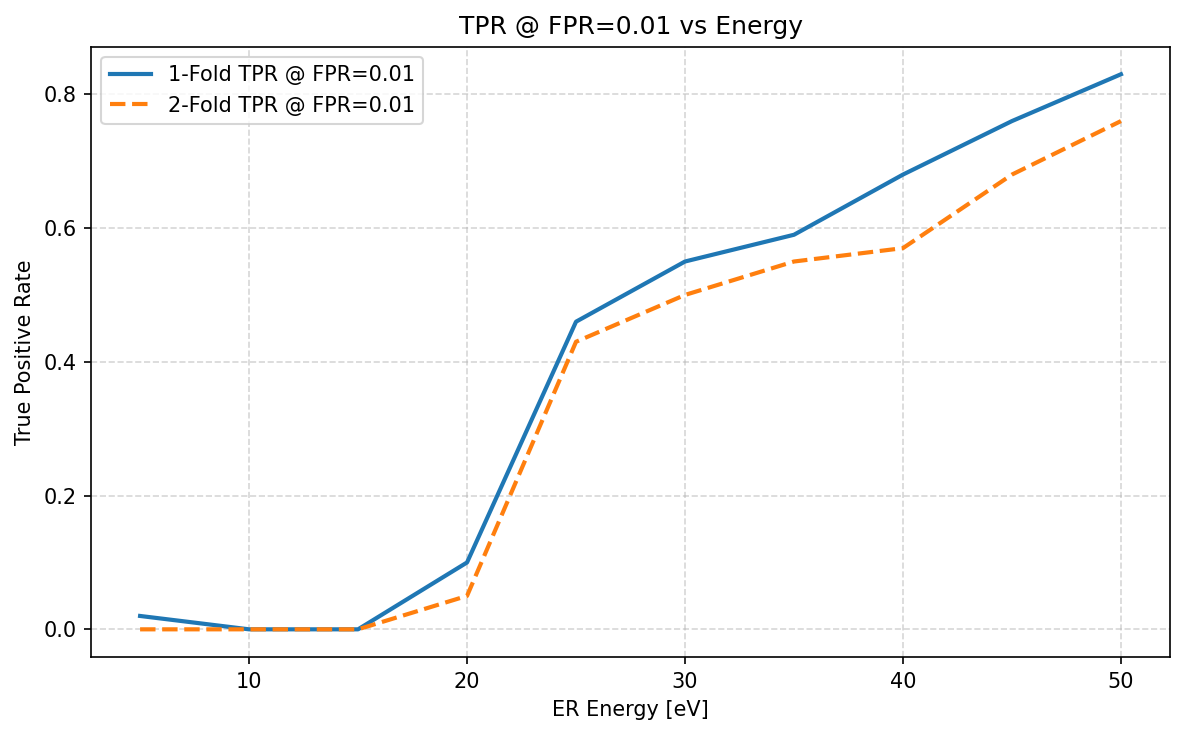

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def compute_amplitudes(traces):
    n_events = traces.shape[0]
    n_channels = traces.shape[1]
    all_amps = np.zeros((n_events, n_channels))

    for i in range(n_events):
        event = traces[i]
        for ch in range(n_channels):
            if ch <= 44:
                amp, _ = trigger_1.fit(event[ch])
            elif ch == 45:
                amp, _ = trigger_2.fit(event[ch])
            else:
                amp, _ = trigger_3.fit(event[ch])
            all_amps[i, ch] = amp

    return all_amps

# === Load background (noise)
loaded_traces_neg = load_traces_from_zstd("/ceph/dwong/trigger_samplesMMC_noise_1000.zst", n_traces=1000)
amps_neg = compute_amplitudes(loaded_traces_neg)

# === Energy scan
energies = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]  # Add more if you have
threshold_value = 3.0
fpr_target = 0.01

auc_1_list = []
auc_2_list = []
tpr_1_list = []
tpr_2_list = []

for energy in energies:
    print(f"Processing ER energy = {energy} eV")

    path = f"/ceph/dwong/trigger_samples/ER/traces_energy_{energy}.zst"
    loaded_traces_pos = load_traces_from_zstd(path, n_traces=100)
    amps_pos = compute_amplitudes(loaded_traces_pos)

    # Scores
    score_1fold_pos = amps_pos.max(axis=1)
    score_1fold_neg = amps_neg.max(axis=1)

    score_2fold_pos = (amps_pos > threshold_value).sum(axis=1)
    score_2fold_neg = (amps_neg > threshold_value).sum(axis=1)

    # Labels
    y_true = np.concatenate([
        np.ones(len(score_1fold_pos)),
        np.zeros(len(score_1fold_neg))
    ])

    # 1-fold
    scores_1 = np.concatenate([score_1fold_pos, score_1fold_neg])
    fpr_1, tpr_1, _ = roc_curve(y_true, scores_1)
    auc_1 = auc(fpr_1, tpr_1)
    auc_1_list.append(auc_1)

    # Get TPR at desired FPR
    idx = np.searchsorted(fpr_1, fpr_target, side="right") - 1
    tpr_1_list.append(tpr_1[idx] if idx >= 0 else 0)

    # 2-fold
    scores_2 = np.concatenate([score_2fold_pos, score_2fold_neg])
    fpr_2, tpr_2, _ = roc_curve(y_true, scores_2)
    auc_2 = auc(fpr_2, tpr_2)
    auc_2_list.append(auc_2)

    idx = np.searchsorted(fpr_2, fpr_target, side="right") - 1
    tpr_2_list.append(tpr_2[idx] if idx >= 0 else 0)

# === Plot AUC vs Energy
plt.figure(figsize=(8, 5), dpi=150)
plt.plot(energies, auc_1_list, label="1-Fold AUC", linewidth=2)
plt.plot(energies, auc_2_list, '--', label="2-Fold AUC", linewidth=2)
plt.xlabel("ER Energy [eV]")
plt.ylabel("AUC")
plt.title("AUC vs Energy")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# === Plot TPR@FPR=0.01 vs Energy
plt.figure(figsize=(8, 5), dpi=150)
plt.plot(energies, tpr_1_list, label="1-Fold TPR @ FPR=0.01", linewidth=2)
plt.plot(energies, tpr_2_list, '--', label="2-Fold TPR @ FPR=0.01", linewidth=2)
plt.xlabel("ER Energy [eV]")
plt.ylabel("True Positive Rate")
plt.title("TPR @ FPR=0.01 vs Energy")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
all_amps.shape

(1000, 54)